In [1]:
import numpy as np

def get_band_data(loc, dates, b, mean=None, std=None):
    y = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy") for d in dates], axis=0)
    y = np.clip(y,0,30)
   
    x = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B{b}_{loc}_{d}.npy") for d in dates], axis=0)
    if mean is None:
        mean = x.mean()
        std = x.std()
    
    x = (x-mean)/std
    
    return x[:,:,:,None], y[:,:,:,None], mean, std

In [ ]:
def get_band_data2(loc, dates, b, mean=None, std=None):
    y = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy") for d in dates], axis=0)
    y = np.clip(y,0,30)

    x11 = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B11_{loc}_{d}.npy") for d in dates], axis=0)
    xi = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B{b}_{loc}_{d}.npy") for d in dates], axis=0)

    if mean is None:
        mean = [x11.mean(),xi.mean()]
        std = [x11.std(),xi.std()]

    x11 = (x11-mean[0])/std[0]
    xi = (xi-mean[1])/std[1]

    x = np.stack((x11,xi), axis=3)
    x11 = None
    xi = None

    return x, y[:,:,:,None], mean, std

In [2]:
def get_band_data3(loc, dates, b, mean=None, std=None):
    y = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy") for d in dates], axis=0)
    y = np.clip(y,0,30)

    x11 = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B11_{loc}_{d}.npy") for d in dates], axis=0)
    x16 = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B16_{loc}_{d}.npy") for d in dates], axis=0)
    xi = np.concatenate([np.load(f"/data/GPM_HIM8/exp_paper/X_B{b}_{loc}_{d}.npy") for d in dates], axis=0)

    if mean is None:
        mean = [x11.mean(),x16.mean(),xi.mean()]
        std = [x11.std(),x16.std(),xi.std()]

    x11 = (x11-mean[0])/std[0]
    x16 = (x16-mean[1])/std[1]
    xi = (xi-mean[2])/std[2]

    x = np.stack((x11,x16,xi), axis=3)
    x11 = None
    x16 = None
    xi = None

    return x, y[:,:,:,None], mean, std

In [ ]:
dates = ["201811","201812","201901","201902"]
val = 0
b = 8
loc = "SYD"
_, _, mean, std = get_band_data(loc, [x for i, x in enumerate(dates) if i!=val], b)
x_test, y_test, _, _ = get_band_data(loc, [x for i, x in enumerate(dates) if i==val], b, mean, std)

In [ ]:
x_test.shape, x_test.min(), x_test.max(), x_test.mean(), x_test.std()

In [ ]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Conv2D, UpSampling2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras import backend as K

def get_unet():
    concat_axis = 3
    inputs = layers.Input(shape=(512, 512, 1))
    #ss = layers.Lambda(lambda x: x[:,:,:,1:], output_shape=(None,512,512,2))(inputs)

    feats = 8#16
    bn0 = BatchNormalization(axis=3)(inputs)
    
    conv1 = layers.Conv2D(feats, (3, 3), activation='relu', padding='same', name='conv1_1')(bn0)
    bn2 = BatchNormalization(axis=3)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn2) #256

    conv2 = layers.Conv2D(2*feats, (3, 3), activation='relu', padding='same')(pool1)
    bn4 = BatchNormalization(axis=3)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn4) #128

    conv3 = layers.Conv2D(4*feats, (3, 3), activation='relu', padding='same')(pool2)
    bn6 = BatchNormalization(axis=3)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn6) #64

    conv4 = layers.Conv2D(8*feats, (3, 3), activation='relu', padding='same')(pool3)
    bn8 = BatchNormalization(axis=3)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn8) #32

    conv5 = layers.Conv2D(16*feats, (3, 3), activation='relu', padding='same')(pool4)
    bn10 = BatchNormalization(axis=3)(conv5)
    pool5 = layers.MaxPooling2D(pool_size=(2, 2))(bn10) #16

    conv6 = layers.Conv2D(32*feats, (3, 3), activation='relu', padding='same')(pool5)
    bn11 = BatchNormalization(axis=3)(conv6)

    up_conv6 = layers.UpSampling2D(size=(2, 2))(bn11) #32
    up7 = layers.concatenate([up_conv6, conv5], axis=concat_axis)

    conv7 = layers.Conv2D(16*feats, (3, 3), activation='relu', padding='same')(up7)
    bn13 = BatchNormalization(axis=3)(conv7)
    
    up_conv5 = layers.UpSampling2D(size=(2, 2))(bn13) #64
    up6 = layers.concatenate([up_conv5, conv4], axis=concat_axis)

    conv6 = layers.Conv2D(8*feats, (3, 3), activation='relu', padding='same')(up6)
    bn15 = BatchNormalization(axis=3)(conv6)

    up_conv6 = layers.UpSampling2D(size=(2, 2))(bn15) #128
    up7 = layers.concatenate([up_conv6, conv3], axis=concat_axis)
    
    conv7 = layers.Conv2D(4*feats, (3, 3), activation='relu', padding='same')(up7)
    bn13 = BatchNormalization(axis=3)(conv7)

    # Rectify last convolution layer to constraint output to positive precipitation values.
    conv8 = layers.Conv2D(1, (1, 1), activation='relu')(bn13)

    model = models.Model(inputs=inputs, outputs=conv8)

    return model

In [ ]:
def accuracy05(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>0.5,y_pred>0.5), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>0.5),tf.math.logical_not(y_pred>0.5)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision05(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>0.5,y_pred>0.5), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>0.5, tf.float32))
    
    return tp/(total_pred+K.epsilon())


def recall05(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>0.5,y_pred>0.5), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>0.5, tf.float32))
    
    return tp/(total_true+K.epsilon())


def accuracy1(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>1,y_pred>1), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>1),tf.math.logical_not(y_pred>1)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision1(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>1,y_pred>1), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>1, tf.float32))
    
    return tp/(total_pred+K.epsilon())


def recall1(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>1,y_pred>1), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>1, tf.float32))
    
    return tp/(total_true+K.epsilon())

def accuracy5(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>5,y_pred>5), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>5),tf.math.logical_not(y_pred>5)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision5(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>5,y_pred>5), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>5, tf.float32))
    
    return tp/(total_pred+K.epsilon())


def recall5(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>5,y_pred>5), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>5, tf.float32))
    
    return tp/(total_true+K.epsilon())


def accuracy10(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>10,y_pred>10), tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.math.logical_not(y_true>10),tf.math.logical_not(y_pred>10)), tf.float32))

    return (tp+tn)/tf.cast(tf.size(y_true), tf.float32)
    

def precision10(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>10,y_pred>10), tf.float32))
    total_pred = tf.reduce_sum(tf.cast(y_pred>10, tf.float32))

    return tp/(total_pred+K.epsilon())


def recall10(y_true, y_pred):
    tp = tf.reduce_sum(tf.cast(tf.math.logical_and(y_true>10,y_pred>10), tf.float32))
    total_true = tf.reduce_sum(tf.cast(y_true>10, tf.float32))
    
    return tp/(total_true+K.epsilon())

In [ ]:
from numpy.random import seed
import pickle
import os

s = 1
seed(s)
tf.random.set_seed(s)

model = get_unet()
print(model.summary())
opt = Adagrad(lr=0.0001)
model.compile(loss='mse', metrics=[accuracy05,precision05,recall05,accuracy1,precision1,recall1,accuracy5,precision5,recall5,accuracy10,precision10,recall10], optimizer=opt)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), shuffle=True, epochs=200, verbose=1)

with open(f'history_3months_200epochs_8chann_v{val}_{loc}_s{s}_b{b}.pkl', 'wb') as f:
    pickle.dump(history.history, f)

model.save(f'model_3months_200epochs_8chann_v{val}_{loc}_s{s}_b{b}.h5')

In [ ]:
from tensorflow.keras.models import load_model

s = 1
mod = load_model(f'model_3months_200epochs_8chann_v{val}_{loc}_s{s}_b{b}.h5', 
                         custom_objects={'accuracy05':accuracy05, 'precision05':precision05, 'recall05':recall05,
                                         'accuracy1':accuracy1, 'precision1':precision1, 'recall1':recall1,
                                         'accuracy5':accuracy5, 'precision5':precision5, 'recall5':recall5,
                                         'accuracy10':accuracy10, 'precision10':precision10, 'recall10':recall10})

yhat = mod.predict(x_test)
yhat.shape

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

i = 600
plt.imshow(y_test[i,:,:,0])
y_test[i,:,:,0].max(), y_test[i,:,:,0].min()

In [ ]:
plt.imshow(yhat[i,:,:,0])
yhat[i,:,:,0].max(), yhat[i,:,:,0].min()

In [ ]:
mod2 = load_model(f'/data/GPM_HIM8/models/model_3months_200epochs_8chann_v{val}_{loc}_s1_b11.h5', 
                         custom_objects={'accuracy05':accuracy05, 'precision05':precision05, 'recall05':recall05,
                                         'accuracy1':accuracy1, 'precision1':precision1, 'recall1':recall1,
                                         'accuracy5':accuracy5, 'precision5':precision5, 'recall5':recall5,
                                         'accuracy10':accuracy10, 'precision10':precision10, 'recall10':recall10})

yhat2 = mod2.predict(x_test)
yhat2.shape

In [ ]:
plt.imshow(yhat2[i,:,:,0])
yhat2[i,:,:,0].max(), yhat2[i,:,:,0].min()

In [ ]:
!ls /data/GPM_HIM8/models/yhat_SY

In [4]:
from tensorflow.keras.models import load_model

dates = ["201811","201812","201901","201902"]

for loc in ["SYD", "NT", "WA"]:
    for val in range(4):
        for b in range(8,17):
            _, _, mean, std = get_band_data3(loc, [x for i, x in enumerate(dates) if i!=val], b)
            x_test, y_test, _, _ = get_band_data3(loc, [x for i, x in enumerate(dates) if i==val], b, mean, std)
            
            for i in range(5):
                print(loc, val, b, i)
                mod = load_model(f'/data/GPM_HIM8/models/model_3months_200epochs_8chann_v{val}_{loc}_s{i+1}_b11_16_{b}.h5', 
                                 custom_objects={'accuracy05':accuracy05, 'precision05':precision05, 'recall05':recall05,
                                                 'accuracy1':accuracy1, 'precision1':precision1, 'recall1':recall1,
                                                 'accuracy5':accuracy5, 'precision5':precision5, 'recall5':recall5,
                                                 'accuracy10':accuracy10, 'precision10':precision10, 'recall10':recall10})

                yhat = mod.predict(x_test)
                np.save(f'/data/GPM_HIM8/models/yhat_{loc}_v{val}_b11_16_{b}_s{i+1}', yhat)

KeyboardInterrupt: 

## Interactive analysis of the results

In [1]:
import warnings
warnings.filterwarnings('ignore')

![alt text](regions_him.png	 "Logo Title Text 1")

### Load Data

In [22]:
!ls /data/GPM_HIM8/exp_paper/

X_B10_NT_201811.npy   X_B14_NT_201811.npy   X_B9_NT_201811.npy
X_B10_NT_201812.npy   X_B14_NT_201812.npy   X_B9_NT_201812.npy
X_B10_NT_201901.npy   X_B14_NT_201901.npy   X_B9_NT_201901.npy
X_B10_NT_201902.npy   X_B14_NT_201902.npy   X_B9_NT_201902.npy
X_B10_NT_201903.npy   X_B14_NT_201903.npy   X_B9_NT_201903.npy
X_B10_NT_201904.npy   X_B14_NT_201904.npy   X_B9_NT_201904.npy
X_B10_SYD_201811.npy  X_B14_SYD_201811.npy  X_B9_SYD_201811.npy
X_B10_SYD_201812.npy  X_B14_SYD_201812.npy  X_B9_SYD_201812.npy
X_B10_SYD_201901.npy  X_B14_SYD_201901.npy  X_B9_SYD_201901.npy
X_B10_SYD_201902.npy  X_B14_SYD_201902.npy  X_B9_SYD_201902.npy
X_B10_SYD_201903.npy  X_B14_SYD_201903.npy  X_B9_SYD_201903.npy
X_B10_SYD_201904.npy  X_B14_SYD_201904.npy  X_B9_SYD_201904.npy
X_B10_WA_201811.npy   X_B14_WA_201811.npy   X_B9_WA_201811.npy
X_B10_WA_201812.npy   X_B14_WA_201812.npy   X_B9_WA_201812.npy
X_B10_WA_201901.npy   X_B14_WA_201901.npy   X_B9_WA_201901.npy
X_B10_WA_201902.npy   X_B14_WA_201902.npy   X_B9_

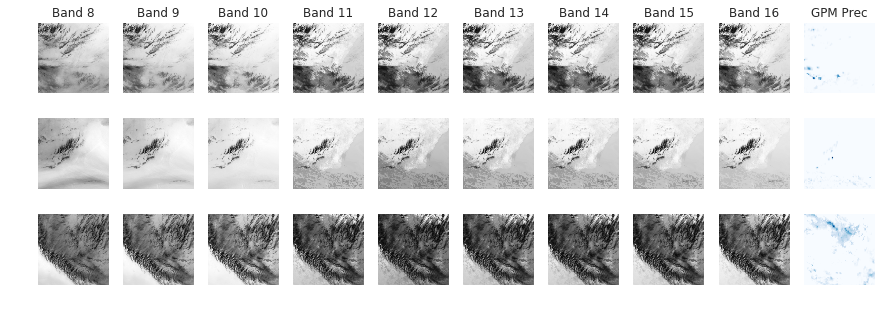

In [55]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

f, axarr = plt.subplots(3, 10, figsize=(15,5))

f.figsize=(26,16)

for band in range(10):
    for event in range(3):
        if band < 9:
            img = np.load(f"/data/GPM_HIM8/exp_paper/X_B{band+8}_SYD_201811.npy")[100*event,:,:]
        else:
            img = np.load(f"/data/GPM_HIM8/exp_paper/Y_SYD_201811.npy")[100*event,:,:]
            
        if band < 9:
            axarr[event,band].imshow(img, cmap=cm.Greys_r)
            if event == 0:
                axarr[event,band].set_title(f"Band {band+8}")
        else:
            axarr[event,band].imshow(img, cmap=cm.Blues)
            if event == 0:
                axarr[event,band].set_title(f"GPM Prec")
            
        axarr[event,band].axis('off')

plt.show()

(128, 128)
(128, 128)
(128, 128)
(128, 128)


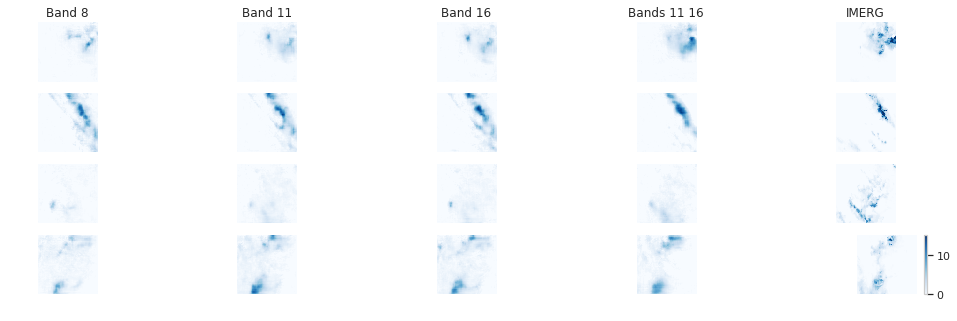

In [78]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
 
f, axarr = plt.subplots(4, 5, figsize=(8,5))

for i, event in enumerate([1284,66,241,925]):
    img = np.load(f'/data/GPM_HIM8/models/yhat_SYD_v0_b8_s1.npy')[event,:,:,0]
    print(img.shape)
    axarr[i,0].imshow(img, vmin=0, vmax=15, cmap=cm.Blues)
    if i == 0:
        axarr[i,0].set_title(f"Band 8") 
    axarr[i,0].axis('off')
    
    img = np.load(f'/data/GPM_HIM8/models/yhat_SYD_v0_b11_s1.npy')[event,:,:,0]
    axarr[i,1].imshow(img, vmin=0, vmax=15, cmap=cm.Blues)
    if i == 0:
        axarr[i,1].set_title(f"Band 11") 
    axarr[i,1].axis('off')
    
    img = np.load(f'/data/GPM_HIM8/models/yhat_SYD_v0_b16_s1.npy')[event,:,:,0]
    axarr[i,2].imshow(img, vmin=0, vmax=15, cmap=cm.Blues)
    if i == 0:
        axarr[i,2].set_title(f"Band 16") 
    axarr[i,2].axis('off')
    
    img = np.load(f'/data/GPM_HIM8/models/yhat_SYD_v0_b11_16_s1.npy')[event,:,:,0]
    axarr[i,3].imshow(img, vmin=0, vmax=15, cmap=cm.Blues)
    if i == 0:
        axarr[i,3].set_title(f"Bands 11 16") 
    axarr[i,3].axis('off')
    
    img = np.load(f"/data/GPM_HIM8/exp_paper/Y_SYD_201811.npy")[event,:,:]
    im = axarr[i,4].imshow(img, vmin=0, vmax=15, cmap=cm.Blues)
    if i == 0:
        axarr[i,4].set_title(f"IMERG") 
    axarr[i,4].axis('off')

f.subplots_adjust(right=1.8)
f.colorbar(im)
    
plt.show()

In [20]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

dates = ["201811","201812","201901","201902"]

yhats = []
y_test = None
location  = None
val_index = None

def f(loc, val,bands):
    global location
    location = loc
    global y_test
    y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{val}.npy")
    y_test = np.clip(y_test,0,30)
    
    global yhats
    yhats = []
    val_i = dates.index(val)
    global val_index 
    val_index = val_i
    
    for b in range(8,17):
        for i in range(5):
            if bands=='1B':
                yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy'))
            elif bands=='2B':
                yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_{b}_s{i+1}.npy'))
    
interactive(f, bands=["1B","2B"], val=dates, loc=["SYD","NT","WA"], continuous_update=False)

interactive(children=(Dropdown(description='loc', options=('SYD', 'NT', 'WA'), value='SYD'), Dropdown(descript…

### Mean precipitation over whole area

In [56]:
def f(n):
    plt.figure(figsize=(13,6))
    plt.plot(y_test.mean(axis=(1,2)))
    plt.axvline(x=n,linewidth=4, color='r')

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot  205,241,412,599,925

interactive(children=(IntSlider(value=717, description='n', max=1434), Output(layout=Layout(height='350px'))),…

### Density of precipitation

In [4]:
def f(n):
    plt.figure(figsize=(13,6))
    plt.plot((y_test*(y_test>0.5)).sum(axis=(1,2))/(1+(y_test>0.5).sum(axis=(1,2))))
    plt.axvline(x=n,linewidth=4, color='r')

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Output(layout=Layout(height='350px'))),…

### Large scale precipitation

In [57]:
def f(n):
    plt.figure(figsize=(13,6))
    plt.plot((y_test>0.2).sum(axis=(1,2)))
    plt.axvline(x=n,linewidth=4, color='r')

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Output(layout=Layout(height='350px'))),…

In [58]:
import xarray as xr

if val_index == 0:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018365.349083-15967-1-2d80aadb-da8a-4a1e-b8af-f3fd47e2be27.nc")
    t_range = slice("2018-11-01","2018-12-01")
if val_index == 1:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018365.349083-15967-1-2d80aadb-da8a-4a1e-b8af-f3fd47e2be27.nc")
    t_range = slice("2018-12-01","2019-01-01")
if val_index == 2:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018589.265387-5956-5-169d76fa-932a-461e-b362-551a527bfd39.nc")
    t_range = slice("2019-01-01","2019-02-01")
if val_index == 3:
    ds = xr.open_dataset("/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018589.265387-5956-5-169d76fa-932a-461e-b362-551a527bfd39.nc")
    t_range = slice("2019-02-01","2019-03-01")

if location == "SYD":
    lons = slice(142,152)
    lats = slice(-31,-41)

if location == "NT":
    lons = slice(133,142)
    lats = slice(-11,-21)

if location == "WA":
    lons = slice(112,124)
    lats = slice(-24,-32)

#print(location, t_range, lats, lons)
f, axarr = plt.subplots(2,1, figsize=(13,6))
axarr[0].plot(ds.crr.sel(time=t_range,longitude=lons,latitude=lats).values.mean(axis=(1,2)))
axarr[0].set_title("ERA5 Convective Rain Rate")

axarr[1].plot(ds.lsrr.sel(time=t_range,longitude=lons,latitude=lats).values.mean(axis=(1,2)))
axarr[1].set_title("ERA5 Large Scale Rain Rate")

pass

FileNotFoundError: [Errno 2] No such file or directory: b'/data/GPM_HIM8/exp_paper/adaptor.mars.internal-1589018365.349083-15967-1-2d80aadb-da8a-4a1e-b8af-f3fd47e2be27.nc'

In [60]:
def f(n):
    f, axarr = plt.subplots(5,10, figsize=(13,6))

    for b in range(9):
        for i in range(5):
            axarr[i,b].imshow(yhats[b*5+i][n,:,:,0], vmin=0, vmax=15, cmap=cm.Blues)
            axarr[i,b].axis('off')
            
    for i in range(5):
        axarr[i,9].imshow(y_test[n,:,:], vmin=0, vmax=15, cmap=cm.Blues)
        axarr[i,9].axis('off')

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Output(layout=Layout(height='350px'))),…

In [19]:
def f(n,t):
    f, axarr = plt.subplots(5,10, figsize=(13,6))

    for b in range(9):
        for i in range(5):
            axarr[i,b].imshow(yhats[b*5+i][n,:,:,0]>t)
            axarr[i,b].axis('off')
            
    for i in range(5):
        axarr[i,9].imshow(y_test[n,:,:]>t)
        axarr[i,9].axis('off')

    #plt.show()

interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

NameError: name 'interactive' is not defined

In [2]:
def f(n,t):
    f, axarr = plt.subplots(1,2, figsize=(13,5))
    val_prec = []
    val_rec = []
    for b in range(9):
        precs = []
        recs = []
        for i in range(5):
            pred = yhats[b*5+i][n,:,:,0]>t
            obs = y_test[n,:,:]>t
            
            precs.append((obs*pred).sum()/pred.sum())
            recs.append((obs*pred).sum()/obs.sum())
        
        val_prec.append(precs)
        val_rec.append(recs)
        
    axarr[0].boxplot(np.array(val_prec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")
    
    axarr[1].boxplot(np.array(val_rec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Dropdown(description='t', options=(0.5,…

### Aggregations over 12 hours (24 time steps)

In [10]:
def f(n,t):
    f, axarr = plt.subplots(1,2, figsize=(13,5))
    val_prec = []
    val_rec = []
    for b in range(9):
        precs = []
        recs = []
        for i in range(5):
            pred = yhats[b*5+i][n-12:n+12,:,:,0]>t
            obs = y_test[n-12:n+12,:,:]>t
            
            precs.append((obs*pred).sum()/pred.sum())
            recs.append((obs*pred).sum()/obs.sum())
        
        val_prec.append(precs)
        val_rec.append(recs)
        
    axarr[0].boxplot(np.array(val_prec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")
    
    axarr[1].boxplot(np.array(val_rec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Dropdown(description='t', options=(0.5,…

### F1 scores over 12 hours
#### F1 = 2*(Recall * Precision) / (Recall + Precision)

In [11]:
def f(n,t):
    f, axarr = plt.subplots(1,1, figsize=(10,5))
    val_f1 = []
    for b in range(9):
        f1s = []
        for i in range(5):
            pred = yhats[b*5+i][n-12:n+12,:,:,0]>t
            obs = y_test[n-12:n+12,:,:]>t
            
            prec = (obs*pred).sum()/pred.sum()
            rec = (obs*pred).sum()/obs.sum()
                
            f1s.append((2*rec*prec)/(rec+prec))
        
        val_f1.append(f1s)
        
    axarr.boxplot(np.array(val_f1).T, labels=[f"B{x}" for x in range(8,17)])
    axarr.set_title(f"Validation F1 (at {t} mm/h)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), t=[0.2,0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Dropdown(description='t', options=(0.2,…

In [3]:
def f(n):
    f, axarr = plt.subplots(1,1, figsize=(7,4))
    val_mse = []
    for b in range(9):
        mses = []
        for i in range(5):
            pred = yhats[b*5+i][n,:,:,0]
            obs = y_test[n,:,:]
            
            mses.append(np.square(obs-pred).mean())
        
        val_mse.append(mses)
        
    axarr.boxplot(np.array(val_mse).T, labels=[f"B{x}" for x in range(8,17)])
    axarr.set_title(f"Validation Mean Square Error (MSE)")


interactive_plot = interactive(f, n=(0, y_test.shape[0]-1), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=717, description='n', max=1434), Output(layout=Layout(height='350px'))),…

<function find_peaks at 0x7feb9c3fae18>


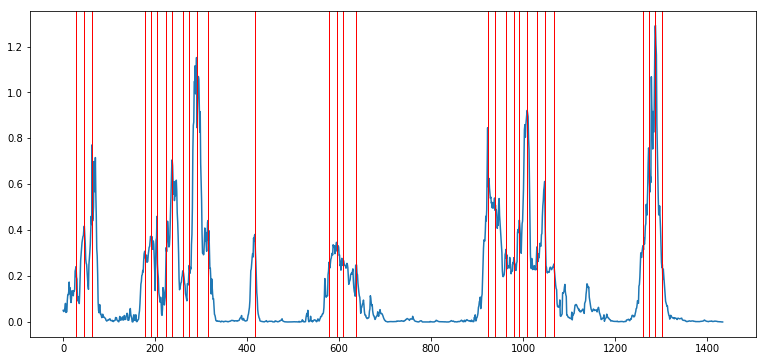

In [5]:
from scipy.signal import find_peaks

print(find_peaks)

prec_mean = y_test.mean(axis=(1,2))

plt.figure(figsize=(13,6))
plt.plot(prec_mean)
peaks, _ = find_peaks(prec_mean, height=.2,distance=12)
for p in peaks:
    plt.axvline(x=p,linewidth=1, color='r')

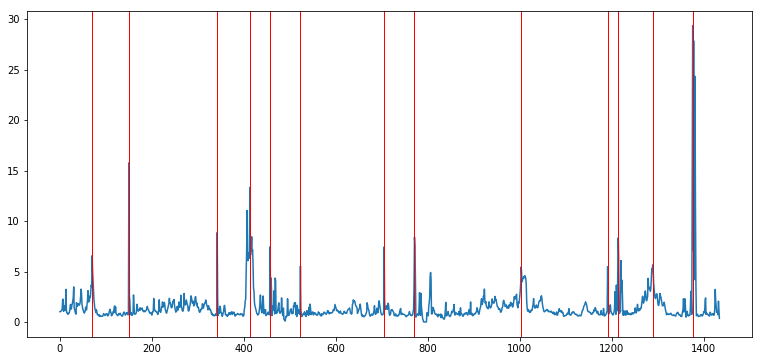

In [6]:
prec_mean = y_test.sum(axis=(1,2))/((y_test>0.2).sum(axis=(1,2))+1)

plt.figure(figsize=(13,6))
plt.plot(prec_mean)
peaks, _ = find_peaks(prec_mean, height=5,distance=12)
for p in peaks:
    plt.axvline(x=p,linewidth=1, color='r')

Text(0.5, 1.0, 'Validation F1 (at 0.5 mm/h)')

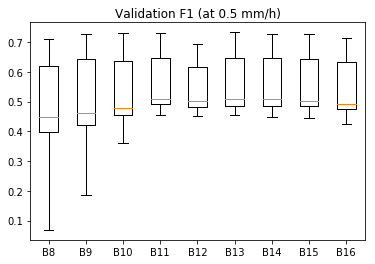

In [7]:
# Detect precipitation peaks

#thressholds
t_min = 0.5
t_max = 4

prec_mean = y_test.mean(axis=(1,2))
peaks1, _ = find_peaks(prec_mean, height=t_min,distance=12)
peaks2, _ = find_peaks(prec_mean, height=t_max,distance=12)
peaks = list(set(peaks1)-set(peaks2))
t = 0.5

val_f1 = []
for b in range(9):
    f1s = []
    for i in range(5):
        for p in peaks[1:-1]:
            pred = yhats[b*5+i][p-12:p+12,:,:,0]>t
            obs = y_test[p-12:p+12,:,:]>t

            prec = (obs*pred).sum()/pred.sum()
            rec = (obs*pred).sum()/obs.sum()

            f1s.append((2*rec*prec)/(rec+prec))

    val_f1.append(f1s)

plt.boxplot(np.array(val_f1).T, labels=[f"B{x}" for x in range(8,17)])
plt.title(f"Validation F1 (at {t} mm/h)")

In [16]:
def plot_performance(yhats, y_test, t, peaks, fname):
    val_prec = []
    val_rec = []
    val_f1 = []
    for b in range(9):
        precs = []
        recs = []
        f1s = []
        for i in range(5):
            for p in peaks[1:-1]:
                
                print(yhats[0].shape, y_test.shape)
                pred = yhats[b*5+i][p-12:p+12,:,:,0]>t
                obs = y_test[p-12:p+12,:,:]>t
                
                print(pred.shape, obs.shape)
                
                if pred.sum()==0 or obs.sum()==0:
                    continue
                
                print("-",b,i,p,pred.sum(), obs.sum())

                prec = (obs*pred).sum()/pred.sum()
                rec = (obs*pred).sum()/obs.sum()

                precs.append(prec)
                recs.append(rec)
                f1s.append((2*rec*prec)/(rec+prec))

        val_prec.append(precs)
        val_rec.append(recs)
        val_f1.append(f1s)

    f, axarr = plt.subplots(1,3, figsize=(15,4))
    axarr[0].boxplot(np.array(val_prec).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")

    axarr[1].boxplot(np.array(val_rec).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")

    axarr[2].boxplot(np.array(val_f1).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[2].set_title(f"Validation F1 (at {t} mm/h)")
    
    f.savefig(fname)
    

dates = ["201811","201812","201901","201902"]
locations = ["SYD","NT","WA"]
locations = ["WA"]

for val_i in range(2,4):
    for loc in locations:
        y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{dates[val_i]}.npy")
        y_test = np.clip(y_test,0,30)
        yhats = []
        for b in range(8,17):
            for i in range(5):
                yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy'))
        
        t_min = 0.1
        t_max = 4

        prec_mean = y_test.mean(axis=(1,2))
        
        t_min = 5
        t_max = 50

        prec_conv = y_test.sum(axis=(1,2))/((y_test>0.2).sum(axis=(1,2))+1)
        peaks1, _ = find_peaks(prec_conv, height=t_min,distance=12)
        peaks2, _ = find_peaks(prec_conv, height=t_max,distance=12)
        peaks = list(set(peaks1)-set(peaks2))
        print("====", len(peaks))
        
        for t in [0.2,0.5,1.0,5.0]:
            plot_performance(yhats, y_test, t, peaks, f'{loc}_{dates[val_i]}_t{t}_conv.png')

KeyboardInterrupt: 

In [ ]:
# Case 2 bands

def plot_performance(yhats, y_test, t, peaks, fname):
    val_prec = []
    val_rec = []
    val_f1 = []
    for b in range(9):
        precs = []
        recs = []
        f1s = []
        for i in range(5):
            for p in peaks[1:-1]:
                print(yhats[0].shape, y_test.shape)
                pred = yhats[b*5+i][p-12:p+12,:,:,0]>t
                obs = y_test[p-12:p+12,:,:]>t
                
                print(pred.shape, obs.shape)
                
                if pred.sum()==0 or obs.sum()==0:
                    continue
                
                print("-",b,i,p,pred.sum(), obs.sum())

                prec = (obs*pred).sum()/pred.sum()
                rec = (obs*pred).sum()/obs.sum()

                precs.append(prec)
                recs.append(rec)
                f1s.append((2*rec*prec)/(rec+prec))

        val_prec.append(precs)
        val_rec.append(recs)
        val_f1.append(f1s)

    f, axarr = plt.subplots(1,3, figsize=(15,4))
    axarr[0].boxplot(np.array(val_prec).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")

    axarr[1].boxplot(np.array(val_rec).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")

    axarr[2].boxplot(np.array(val_f1).T, notch=True, vert=True, patch_artist=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
    axarr[2].set_title(f"Validation F1 (at {t} mm/h)")
    
    f.savefig(fname)
    

dates = ["201811","201812","201901","201902"]
locations = ["SYD","NT","WA"]

for val_i in range(0,4):
    for loc in locations:
        y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{dates[val_i]}.npy")
        y_test = np.clip(y_test,0,30)
        yhats = []
        for b in range(8,17):
            for i in range(5):
                yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_{b}_s{i+1}.npy'))
        
        t_min = 5
        t_max = 50

        prec_mean = y_test.mean(axis=(1,2))
        prec_conv = y_test.sum(axis=(1,2))/((y_test>0.2).sum(axis=(1,2))+1)
        peaks1, _ = find_peaks(prec_conv, height=t_min,distance=12)
        peaks2, _ = find_peaks(prec_conv, height=t_max,distance=12)
        peaks = list(set(peaks1)-set(peaks2))
        print("====", len(peaks))
        
        for t in [0.2,0.5,1.0,5]:
            plot_performance(yhats, y_test, t, peaks, f'{loc}_{dates[val_i]}_2b_t{t}_conv.png')

In [8]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

dates = ["201811","201812","201901","201902"]

def f(loc, val):
    y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{val}.npy")
    y_test = np.clip(y_test,0,30)
    prec_mean = y_test.mean(axis=(1,2))
    #prec_conv = y_test.sum(axis=(1,2))/((y_test>0.5).sum(axis=(1,2))+1)
    #prec_conv = (y_test*(y_test>0.5)).sum(axis=(1,2))/(1+(y_test>0.5).sum(axis=(1,2)))
    prec_ls = (y_test>0.2).sum(axis=(1,2))
    
    plt.figure(figsize=(13,6))
    plt.plot(prec_ls)
    peaks, _ = find_peaks(prec_ls, height=5000, distance=12)
    for p in peaks:
        plt.axvline(x=p,linewidth=1, color='r')
    
interactive(f, val=dates, loc=["SYD", "NT", "WA"], continuous_update=False)

interactive(children=(Dropdown(description='loc', options=('SYD', 'NT', 'WA'), value='SYD'), Dropdown(descript…

[ 63 197 233 290 308 589 614 930]
[ 565  583  597  621  640  679 1445]
[ 185  808 1205 1385]
[]
[  70  413 1003 1289]
[ 666  690  713  746  923  985 1266 1320]
[ 312  328  469  485  647  727  767  781  907 1036 1139 1154 1196 1335
 1352 1373 1395]
[ 34 109 322 341 357 397 829 920 939]
[ 63 197 233 290 308 589 614 930]
[ 565  583  597  621  640  679 1445]
[ 185  808 1205 1385]
[]
[  70  413 1003 1289]
[ 666  690  713  746  923  985 1266 1320]
[ 312  328  469  485  647  727  767  781  907 1036 1139 1154 1196 1335
 1352 1373 1395]
[ 34 109 322 341 357 397 829 920 939]
[ 63 197 233 290 308 589 614 930]
[ 565  583  597  621  640  679 1445]
[ 185  808 1205 1385]
[]
[  70  413 1003 1289]
[ 666  690  713  746  923  985 1266 1320]
[ 312  328  469  485  647  727  767  781  907 1036 1139 1154 1196 1335
 1352 1373 1395]
[ 34 109 322 341 357 397 829 920 939]
[ 63 197 233 290 308 589 614 930]
[ 565  583  597  621  640  679 1445]
[ 185  808 1205 1385]
[]
[  70  413 1003 1289]
[ 666  690  713  746  92

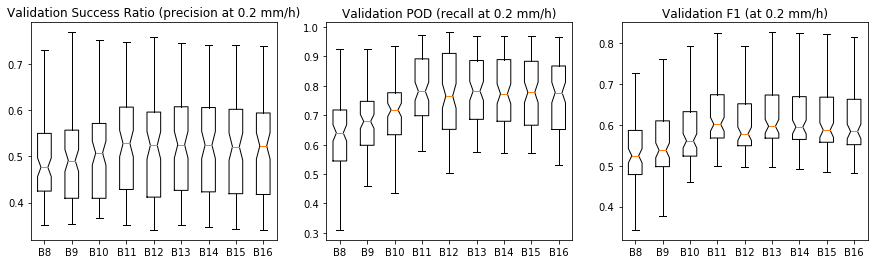

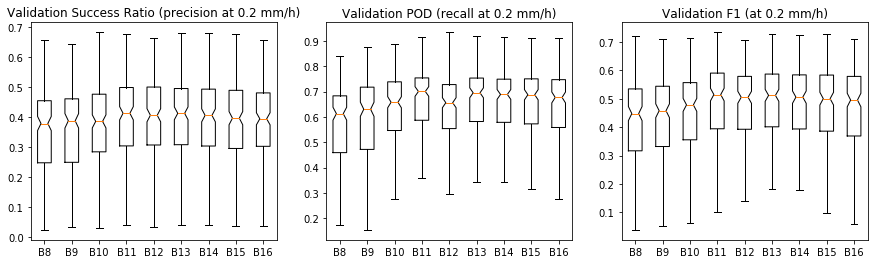

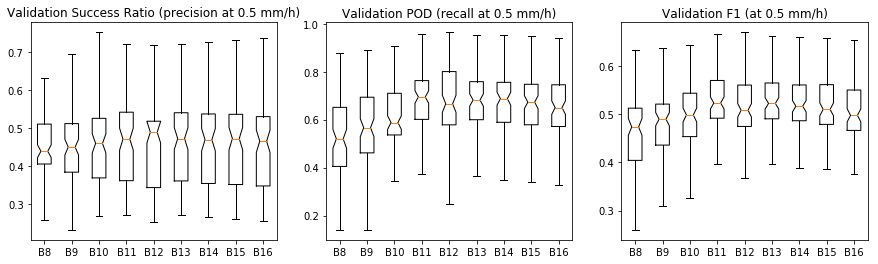

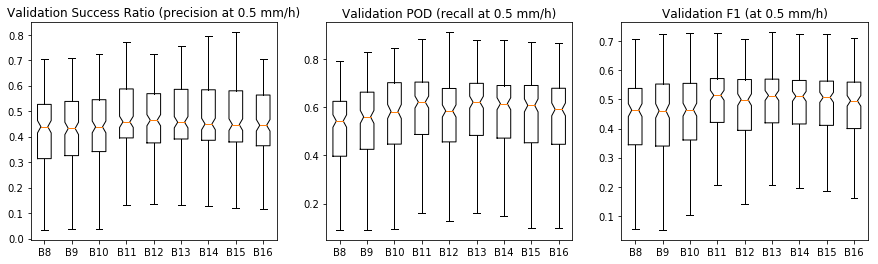

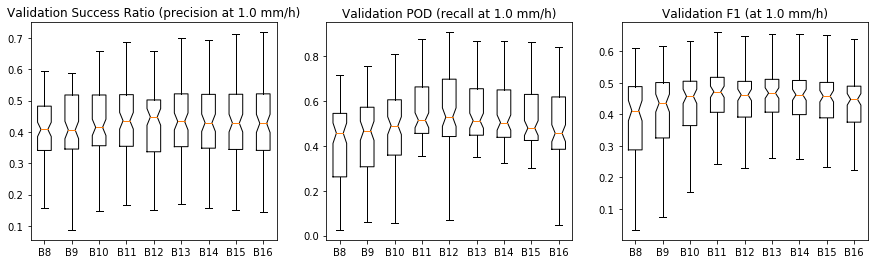

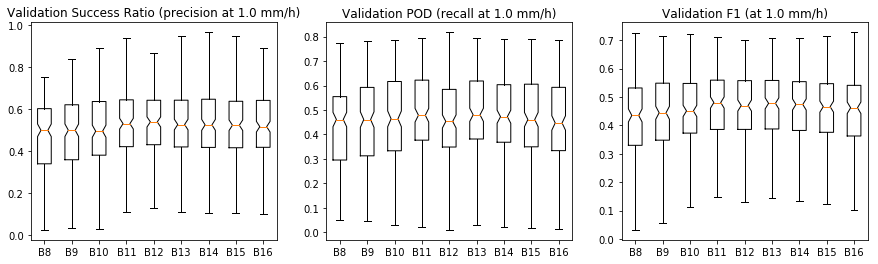

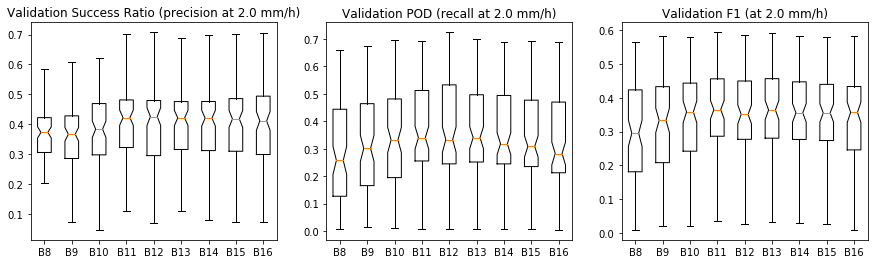

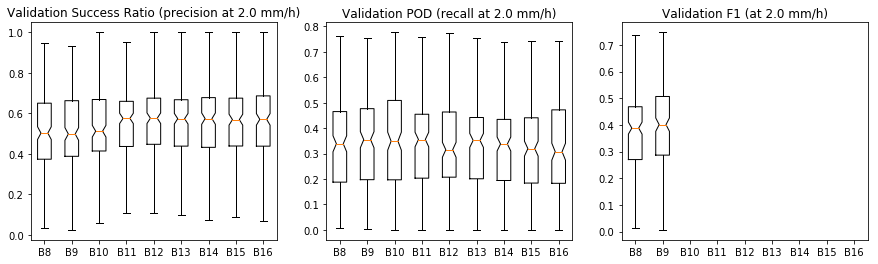

In [51]:

dates = ["201811","201812","201901","201902"]
locations = ["SYD"]#,"NT","WA"]

for loc in locations:
    for t in [.2,.5,1.,2.]:
        for prec_type in ["ls", "conv"]:
            precs = [[],[],[],[],[],[],[],[],[]]
            recs = [[],[],[],[],[],[],[],[],[]]
            f1s = [[],[],[],[],[],[],[],[],[]]
            for val_i in range(0,4):
                y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{dates[val_i]}.npy")
                y_test = np.clip(y_test,0,30)
                yhats = []
                for b in range(8,17):
                    for i in range(5):
                        yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy'))

                if prec_type == "conv":
                    prec_conv = (y_test*(y_test>0.5)).sum(axis=(1,2))/(1+(y_test>0.5).sum(axis=(1,2)))
                    peaks, _ = find_peaks(prec_conv, height=5,distance=12)
                elif prec_type == "ls":
                    prec_ls = (y_test>0.2).sum(axis=(1,2))
                    peaks, _ = find_peaks(prec_ls, height=5000,distance=12)

                print(peaks)

                for b in range(9):
                    for i in range(5):
                        for p in peaks:
                            pred = yhats[b*5+i][p-12:p+12,:,:,0]>t
                            obs = y_test[p-12:p+12,:,:]>t

                            if pred.sum()==0 or obs.sum()==0:
                                continue

                            prec = (obs*pred).sum()/pred.sum()
                            rec = (obs*pred).sum()/obs.sum()

                            precs[b].append(prec)
                            recs[b].append(rec)
                            f1s[b].append((2*rec*prec)/(rec+prec))

            f, axarr = plt.subplots(1,3, figsize=(15,4))
            axarr[0].boxplot(np.array(precs).T, notch=True, vert=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
            axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")

            axarr[1].boxplot(np.array(recs).T, notch=True, vert=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
            axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")

            axarr[2].boxplot(np.array(f1s).T, notch=True, vert=True, showfliers=False, labels=[f"B{x}" for x in range(8,17)])
            axarr[2].set_title(f"Validation F1 (at {t} mm/h)")

            f.savefig(f"{loc}_t{t}_{prec_type}.png")

In [53]:
!pwd

/home/pl5189/github/pluvi_pondus/gpm_him8/output_analysis


In [9]:
def f(t):
    f, axarr = plt.subplots(1,2, figsize=(13,5))
    val_prec = []
    val_rec = []
    for b in range(9):
        precs = []
        recs = []
        for i in range(5):
            pred = yhats[b*5+i][:,:,:,0]>t
            obs = y_test[:,:,:]>t
            
            precs.append((obs*pred).sum()/pred.sum())
            recs.append((obs*pred).sum()/obs.sum())
        
        val_prec.append(precs)
        val_rec.append(recs)
        
    axarr[0].boxplot(np.array(val_prec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[0].set_title(f"Validation Success Ratio (precision at {t} mm/h)")
    
    axarr[1].boxplot(np.array(val_rec).T, labels=[f"B{x}" for x in range(8,17)])
    axarr[1].set_title(f"Validation POD (recall at {t} mm/h)")

interactive_plot = interactive(f, t=[0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='t', options=(0.5, 1, 5, 10), value=0.5), Output(layout=Layout(heig…

In [18]:
def f(t):
    f, axarr = plt.subplots(1,1, figsize=(10,5))
    val_f1 = []
    for b in range(9):
        f1s = []
        for i in range(5):
            pred = yhats[b*5+i][:,:,:,0]>t
            obs = y_test[:,:,:]>t
            
            prec = (obs*pred).sum()/pred.sum()
            rec = (obs*pred).sum()/obs.sum()
                
            f1s.append((2*rec*prec)/(rec+prec))
        
        val_f1.append(f1s)
        
    axarr.boxplot(np.array(val_f1).T, labels=[f"B{x}" for x in range(8,17)])
    axarr.set_title(f"Validation F1 (at {t} mm/h)")


interactive_plot = interactive(f, t=[0.2,0.5,1,5,10], continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='t', options=(0.2, 0.5, 1, 5, 10), value=0.2), Output(layout=Layout…

/home/pl5189/github/panpluie/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/home/pl5189/github/panpluie/venv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/pl5189/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/pl5189/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/pl5189/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/pl5189/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


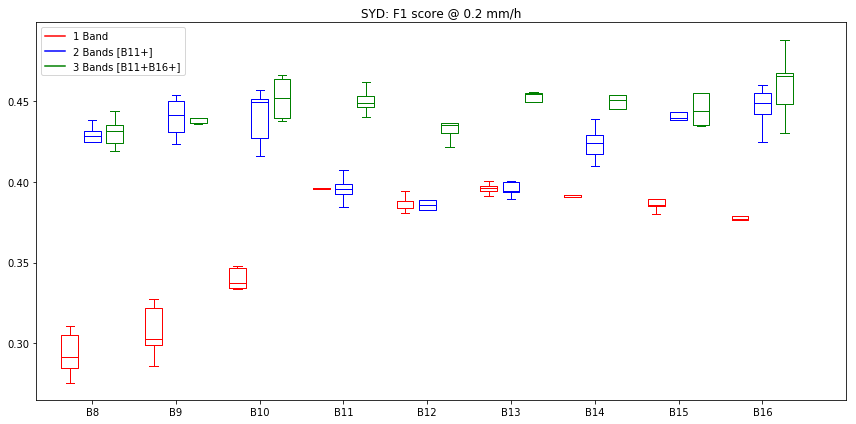

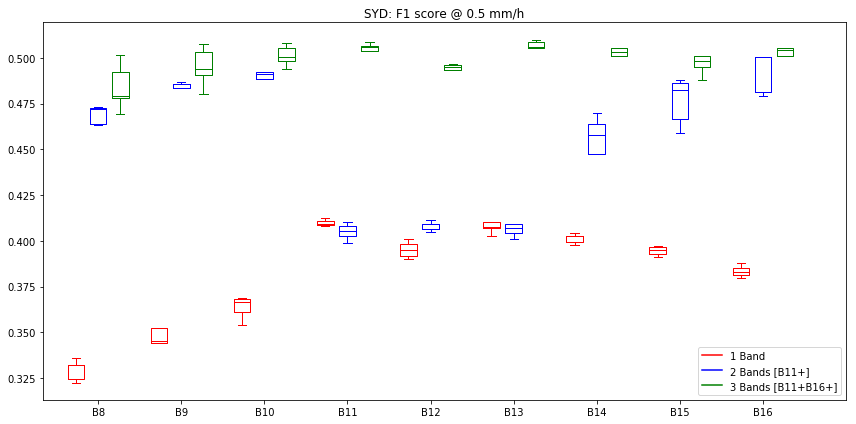

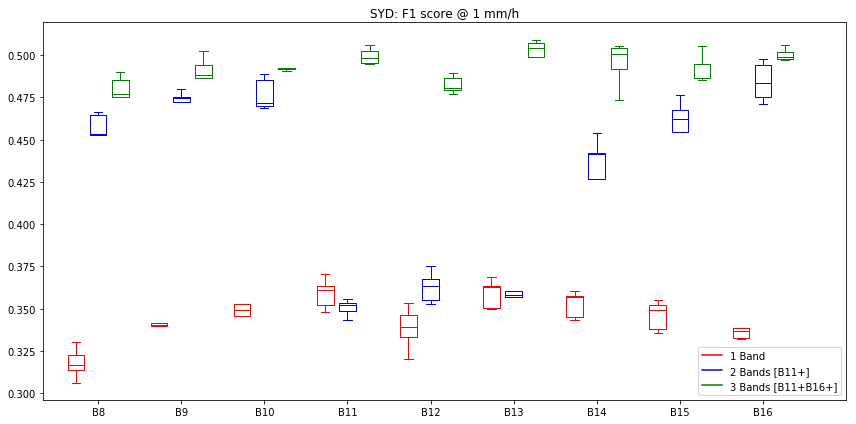

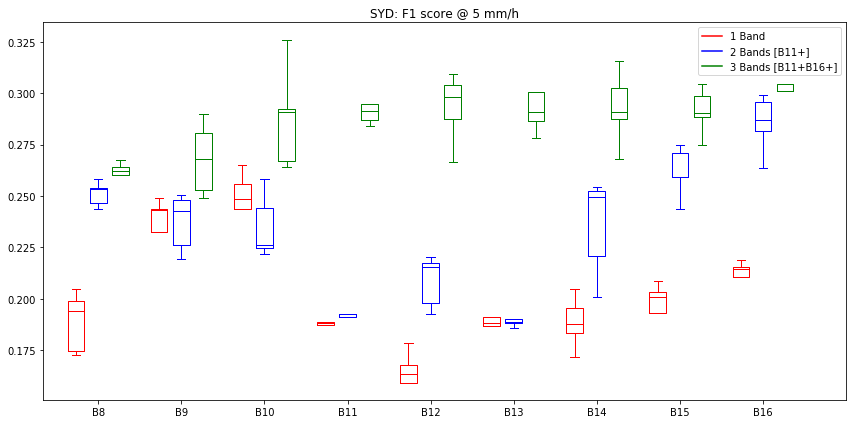

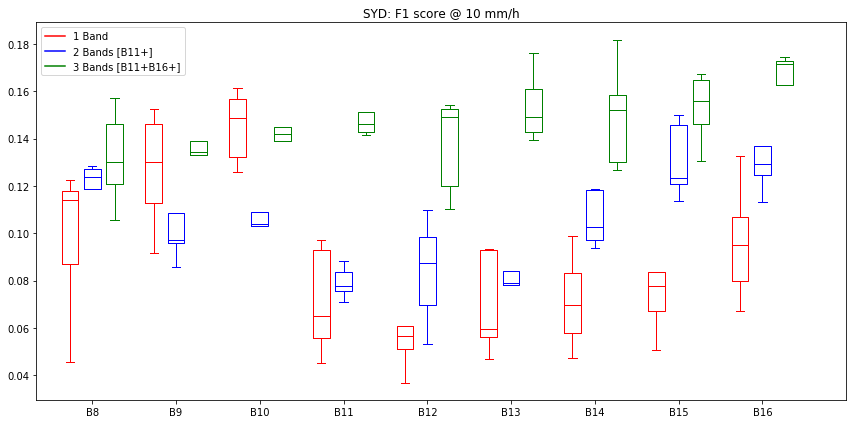

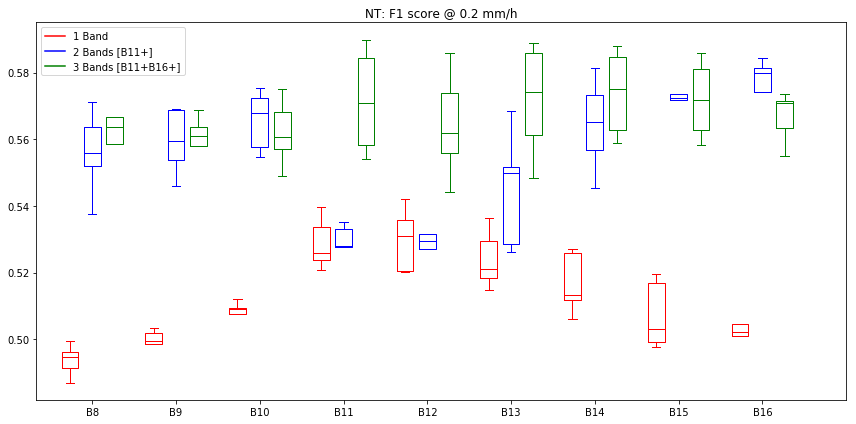

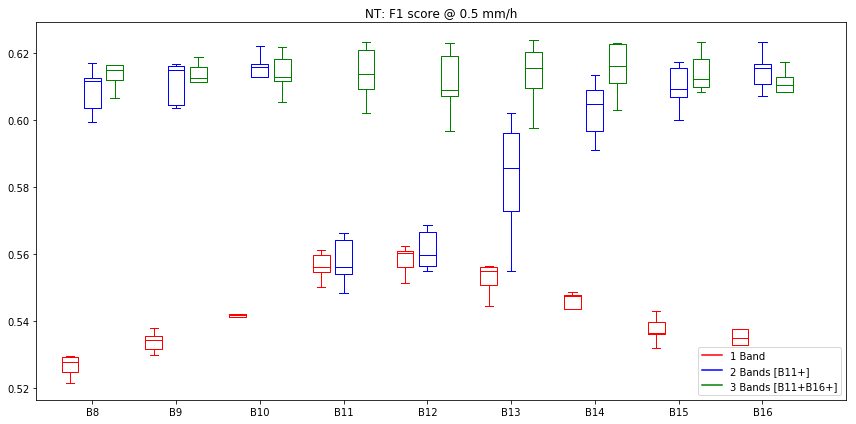

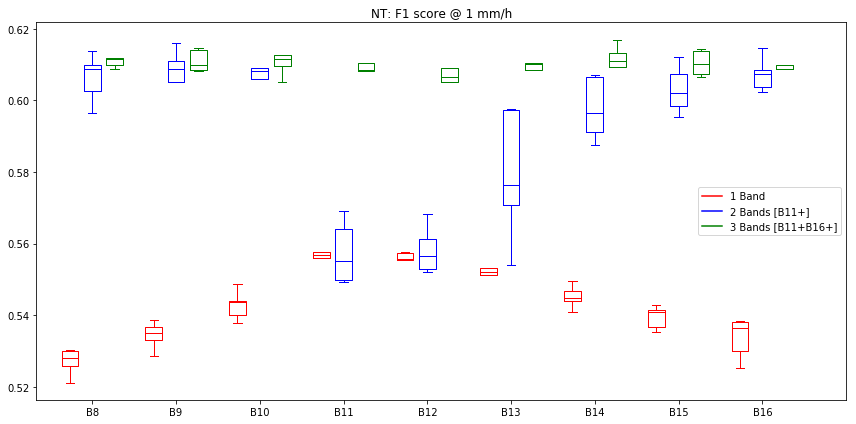

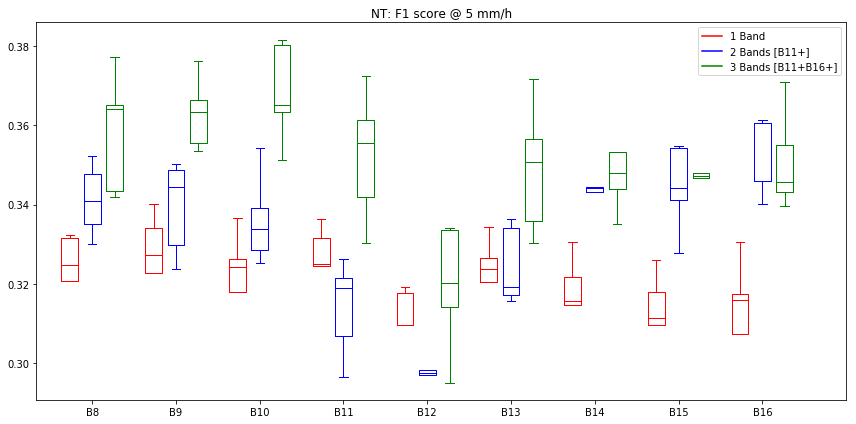

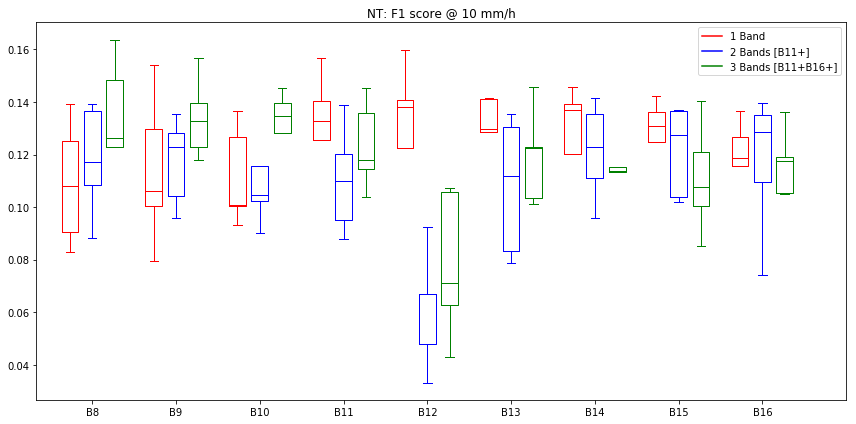

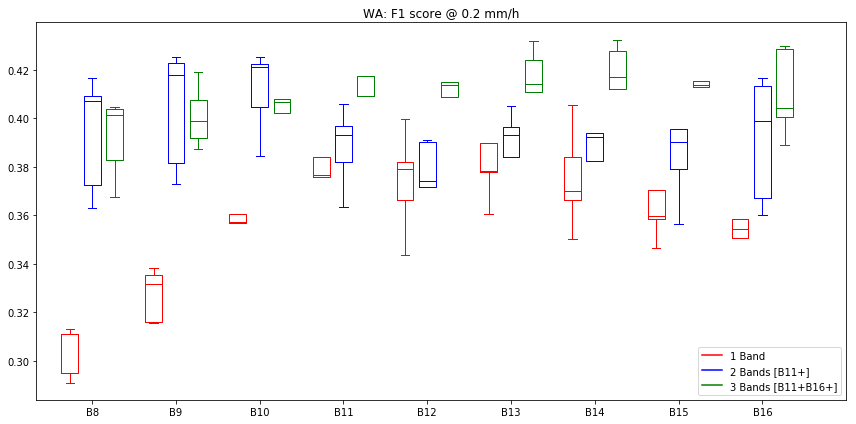

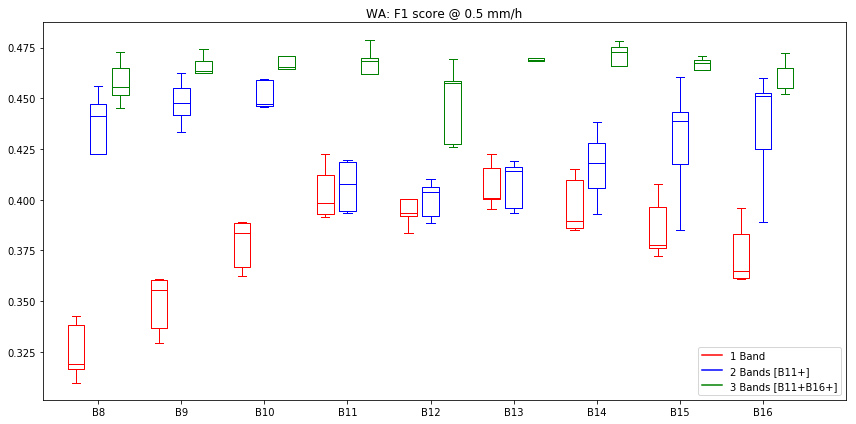

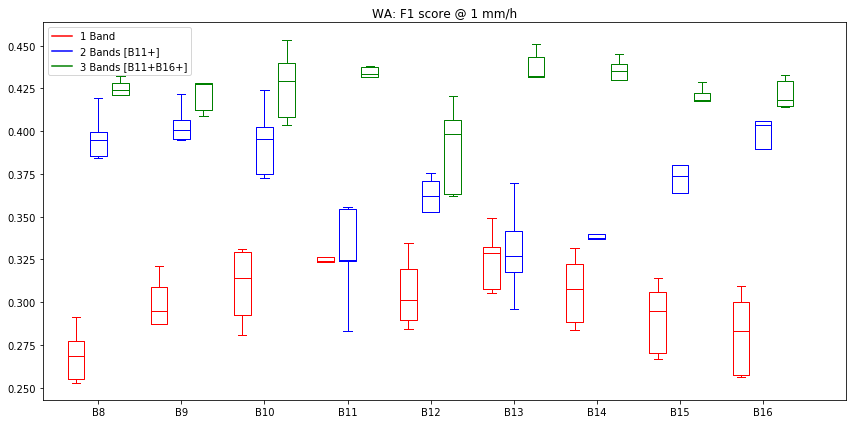

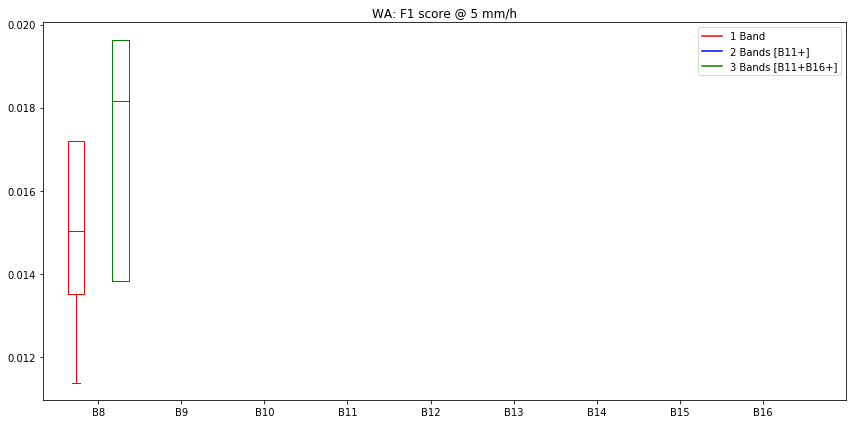

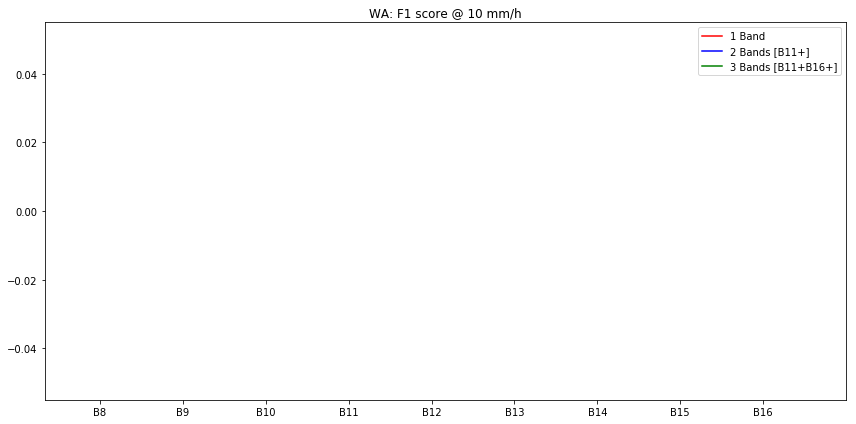

In [35]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

dates = ["201811","201812","201901","201902"]

def f(loc, bands, t):
    
    for val_i, d in enumerate(dates):
        y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy")
        y_test = np.clip(y_test,0,30)
    
        val_f1 = []
        
        yhats = []
        for b in range(8,17):
            f1s = []
            for i in range(5):
                if bands=='1B':
                    yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy'))
                elif bands=='2B':
                    yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_{b}_s{i+1}.npy'))
                elif bands=='3B':
                    yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_16_{b}_s{i+1}.npy'))
                    
                pred = yhats[(b-8)*5+i][:,:,:,0]>t
                obs = y_test[:,:,:]>t

                prec = (obs*pred).sum()/pred.sum()
                rec = (obs*pred).sum()/obs.sum()

                f1s.append((2*rec*prec)/(rec+prec))
                
            val_f1.append(f1s) 
            
    #print(np.array(val_f1).T.shape)
    return np.array(val_f1).T
    
    f, axarr = plt.subplots(1,1, figsize=(10,5))
    axarr.boxplot(np.array(val_f1).T, labels=[f"B{x}" for x in range(8,17)])
    axarr.set_title(f"Validation F1 (at {t} mm/h)")
    plt.savefig(f'F1_{loc}_t{t}_{bands}.png')
    
    
#interactive(f, bands=["1B","2B"], t=[0.2,0.5,1,5,10], loc=["SYD","NT","WA"], continuous_update=False)


for loc in ["SYD","NT","WA"]:
    for t in [0.2,0.5,1,5,10]:
        data = []
        for bands in ["1B","2B","3B"]:
            arr = f(bands=bands, t=t, loc=loc)
            data.append(arr)
            
        data = np.stack(data, axis=0)
        generate_3boxplot(data, loc, t)

In [18]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def generate_3boxplot(data, region, threshold):
    ticks = [f"B{x}" for x in range(8,17)]
    plt.figure(figsize=(12,6))

    bpl = plt.boxplot(data[0,:,:], positions=np.array(range(9))*3.0-0.8, sym='', widths=0.6)
    bpm = plt.boxplot(data[1,:,:], positions=np.array(range(9))*3.0, sym='', widths=0.6)
    bpr = plt.boxplot(data[2,:,:], positions=np.array(range(9))*3.0+0.8, sym='', widths=0.6)
    set_box_color(bpl, 'red')
    set_box_color(bpm, 'blue')
    set_box_color(bpr, 'green')

    plt.plot([], c='red', label='1 Band')
    plt.plot([], c='blue', label='2 Bands [B11+]')
    plt.plot([], c='green', label='3 Bands [B11+B16+]')
    plt.legend()
    
    plt.title(f"{region}: F1 score @ {threshold} mm/h")

    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.xlim(-2, len(ticks)*3)
    #plt.ylim(0.25, 0.55)
    plt.tight_layout()
    plt.savefig(f"{region}_t{threshold}.png")
    #plt.show()
    
def generate_4boxplot(data, region, threshold):
    ticks = [f"B{x}" for x in range(8,17)]
    plt.figure(figsize=(12,6))

    bpl = plt.boxplot(data[0,:,:], positions=np.array(range(9))*3.0-0.9, sym='', widths=0.6)
    bpm = plt.boxplot(data[1,:,:], positions=np.array(range(9))*3.0-0.3, sym='', widths=0.6)
    bpr = plt.boxplot(data[2,:,:], positions=np.array(range(9))*3.0+0.3, sym='', widths=0.6)
    bpo = plt.boxplot(data[3,:,:], positions=np.array(range(9))*3.0+0.9, sym='', widths=0.6)
    set_box_color(bpl, 'red')
    set_box_color(bpm, 'blue')
    set_box_color(bpr, 'green')
    set_box_color(bpo, 'orange')

    plt.plot([], c='red', label='1 Band')
    plt.plot([], c='blue', label='2 Bands [B11+]')
    plt.plot([], c='green', label='3 Bands [B11+B16+]')
    plt.plot([], c='orange', label='2 Bands Dense B11,B16')
    plt.legend()
    
    plt.title(f"{region}: F1 score @ {threshold} mm/h")

    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.xlim(-2, len(ticks)*3)
    plt.tight_layout()
    plt.savefig(f"{region}_t{threshold}_dense.png")

(5, 9)
(5, 9)
(5, 9)
(5, 9)
(5, 9)


KeyboardInterrupt: 

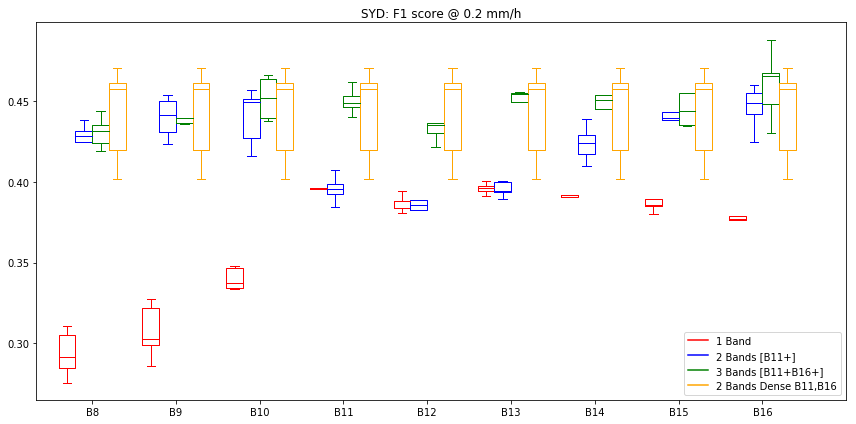

In [22]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

dates = ["201811","201812","201901","201902"]

def f(loc, bands, t):
    
    for val_i, d in enumerate(dates):
        
        if bands == 'Dense' and loc=='SYD':
            y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_DENSE_SE_{d}.npy")
            y_test = np.clip(y_test,0,30)
            
        elif bands == 'Dense':
            y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_DENSE_{loc}_{d}.npy")
            y_test = np.clip(y_test,0,30)
            
        else:
            y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy")
            y_test = np.clip(y_test,0,30)
    
        val_f1 = []
        
        yhats = []
        for b in range(8,17):
            f1s = []
            for i in range(5):
                if bands=='1B':
                    yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy'))
                elif bands=='2B':
                    yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_{b}_s{i+1}.npy'))
                elif bands=='3B':
                    yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_16_{b}_s{i+1}.npy'))
                elif bands=='Dense':
                    if loc=='SYD':
                        yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_dense_SE_v{val_i}_b11_16_s{i+1}.npy'))
                    else:
                        yhats.append(np.load(f'/data/GPM_HIM8/models/yhat_dense_{loc}_v{val_i}_b11_16_s{i+1}.npy'))
                    
                pred = yhats[(b-8)*5+i][:,:,:,0]>t
                obs = y_test[:,:,:]>t

                prec = (obs*pred).sum()/pred.sum()
                rec = (obs*pred).sum()/obs.sum()

                f1s.append((2*rec*prec)/(rec+prec))
                
            val_f1.append(f1s) 
            
    print(np.array(val_f1).T.shape)
    return np.array(val_f1).T
    
    f, axarr = plt.subplots(1,1, figsize=(10,5))
    axarr.boxplot(np.array(val_f1).T, labels=[f"B{x}" for x in range(8,17)])
    axarr.set_title(f"Validation F1 (at {t} mm/h)")
    plt.savefig(f'F1_{loc}_t{t}_{bands}.png')


for loc in ["SYD","NT","WA"]:
    for t in [0.2,0.5,1,5,10]:
        data = []
        for bands in ["1B","2B","3B","Dense"]:
            arr = f(bands=bands, t=t, loc=loc)
            data.append(arr)
            
        data = np.stack(data, axis=0)
        generate_4boxplot(data, loc, t)

In [37]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

dates = ["201811","201812","201901","201902"]

def f(loc):
    
    for val_i, d in enumerate(dates):
        print(d)
        for i in range(5):
            print(i)
            
            y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy")
            y_test = np.clip(y_test,0,30)
            yhat= np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_16_s{i+1}.npy')[:,:,:,0]
            

            print("2B", np.mean(np.square(yhat-y_test)))
            
            if loc=='SYD':
                y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_DENSE_SE_{d}.npy")
                y_test = np.clip(y_test,0,30)
                yhat = np.load(f'/data/GPM_HIM8/models/yhat_dense_SE_v{val_i}_b11_16_s{i+1}.npy')[:,:,:,0]
            else:
                y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_DENSE_{loc}_{d}.npy")
                y_test = np.clip(y_test,0,30)
                yhat = np.load(f'/data/GPM_HIM8/models/yhat_dense_{loc}_v{val_i}_b11_16_s{i+1}.npy')[:,:,:,0]
            
            print("Dense", np.mean(np.square(yhat-y_test)))
        
        print()


for loc in ["SYD"]:#,"NT","WA"]:
    f(loc)


201811
0
2B 0.5225666
Dense 0.53418744
1
2B 0.5593397
Dense 0.5604988
2
2B 0.54906297
Dense 0.5493415
3
2B 0.5300454
Dense 0.5567862
4
2B 0.53835166
Dense 0.5367143

201812
0
2B 0.8414973
Dense 0.9392692
1
2B 0.86513686
Dense 0.9217431
2
2B 0.8673285
Dense 0.8977391
3
2B 0.88244355
Dense 0.9443785
4
2B 0.901461
Dense 0.90591717

201901
0
2B 0.5539109
Dense 0.5764783
1
2B 0.5783369
Dense 0.59415936
2
2B 0.5821465
Dense 0.5760638
3
2B 0.58131516
Dense 0.63075644
4
2B 0.5955972
Dense 0.6083127

201902
0
2B 0.30040053
Dense 0.3087521
1
2B 0.30329424
Dense 0.32743937
2
2B 0.3099204
Dense 0.30664662
3
2B 0.31353387
Dense 0.32697284
4
2B 0.31066316
Dense 0.32370588



In [39]:
x = np.load(f"/data/GPM_HIM8/exp_paper/X_DENSE_B11_NT_201811.npy")
x.shape

(1366, 3, 512, 512)

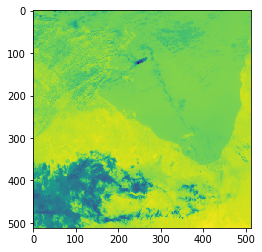

In [40]:
plt.imshow(x[0,0,:,:])

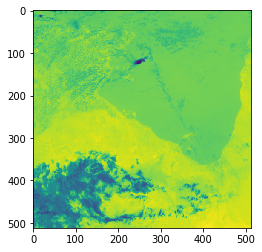

In [41]:
plt.imshow(x[0,1,:,:])

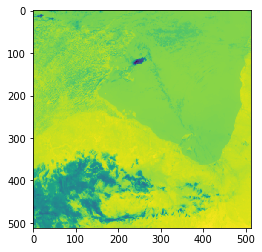

In [42]:
plt.imshow(x[0,2,:,:])

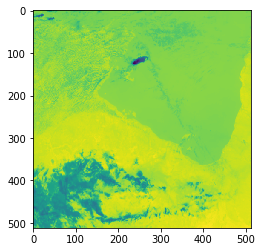

In [43]:
plt.imshow(x[1,0,:,:])

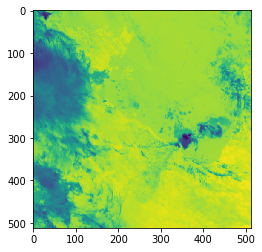

In [44]:
plt.imshow(x[1000,0,:,:])

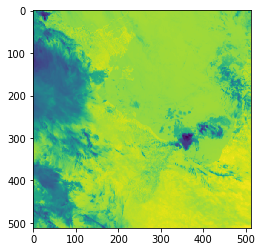

In [45]:
plt.imshow(x[1000,1,:,:])

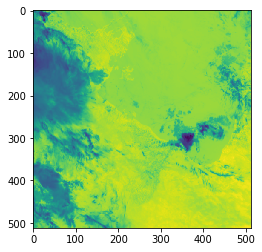

In [46]:
plt.imshow(x[1000,2,:,:])

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def stat_generator(bands):
    
    dates = ["201811","201812","201901","201902"]
    data = []
    
    for loc in ["SYD","WA","NT"]:
        for b in range(8,17):
            scores = []
            for val_i, d in enumerate(dates):
                y_test = np.load(f"/data/GPM_HIM8/exp_paper/Y_{loc}_{d}.npy")
                y_test = np.clip(y_test,0,30)

                for i in range(5):
                    if bands=='1B':
                        yhat = np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b{b}_s{i+1}.npy')
                    elif bands=='2B':
                        yhat = np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_{b}_s{i+1}.npy')
                    elif bands=='3B':
                        yhat = np.load(f'/data/GPM_HIM8/models/yhat_{loc}_v{val_i}_b11_16_{b}_s{i+1}.npy')

                    pred = yhat[:,:,:,0]
                    obs = y_test[:,:,:]
                    mse = np.mean(np.square(obs-pred))

                    for t in [0.2,1.0,5.0]:

                        pred = yhat[:,:,:,0]>t
                        obs = y_test[:,:,:]>t
                        prec = (obs*pred).sum()/pred.sum()
                        rec = (obs*pred).sum()/obs.sum()
                        f1 = (2*rec*prec)/(rec+prec)

                        data.append({'Loc': loc,
                                     'Band': f'B{b}',
                                     'MSE': mse,
                                     'Rec': rec,
                                     'Prec': prec,
                                     'F1': f1,
                                     'threshold [mm/h]': t})

        
    return pd.DataFrame(data)

1B SYD
1B NT
1B WA


/home/pl5189/github/panpluie/venv/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/home/pl5189/github/panpluie/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


2B SYD
2B NT
2B WA
3B SYD


/home/pl5189/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3B NT
3B WA


<Figure size 432x288 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

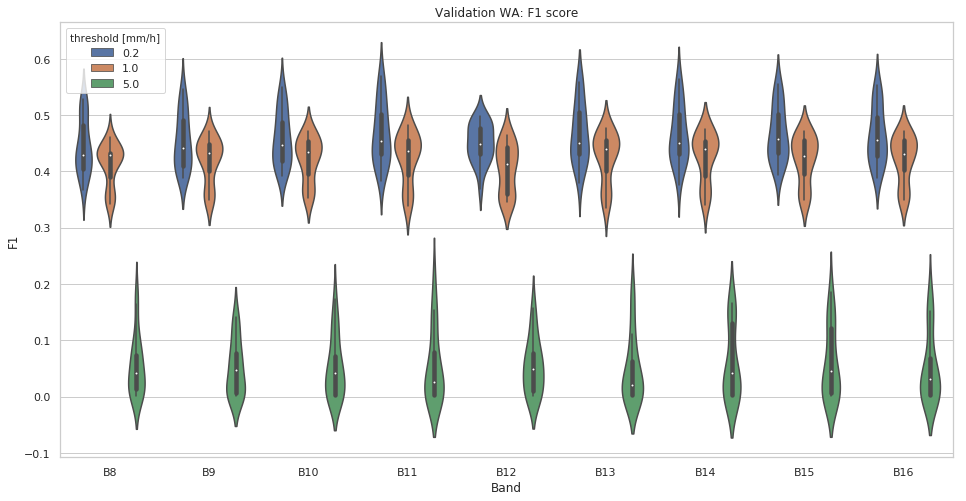

In [78]:
loc_map = {"SYD":"SE","NT":"NT","WA":"WA"}
scr_map = {"MSE":"MSE","F1":"F1","Rec":"Recall","Prec":"Precision"}

for bands in ["1B","2B","3B"]:
    for loc in ["SYD","NT","WA"]:

        print(bands, loc)
        data = stat_generator(loc=loc, bands=bands)

        for scr in ["Prec","Rec","F1"]:
            plt.clf()
            plt.figure(figsize=(16,8))
            ax = sns.violinplot(data=data, x='Band', y=scr, hue='threshold [mm/h]')
            ax.set_title(f"Validation {loc_map[loc]}: {scr_map[scr]} score")
            plt.plot()
            #plt.savefig(f'{scr}_{loc}_{bands}.png')

In [17]:
bands = "3B"

data = stat_generator(bands=bands)
data

/home/pl5189/github/panpluie/venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/pl5189/github/panpluie/venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars


,Loc,Band,MSE,Rec,Prec,F1,threshold [mm/h]
0,SYD,B8,0.550069,0.710367,0.420969,0.528654,0.2
1,SYD,B8,0.550069,0.592315,0.418565,0.490508,1.0
2,SYD,B8,0.550069,0.252564,0.321594,0.282929,5.0
3,SYD,B8,0.538809,0.734041,0.439200,0.549573,0.2
4,SYD,B8,0.538809,0.597212,0.426441,0.497582,1.0
...,...,...,...,...,...,...,...
1615,NT,B16,0.810334,0.637551,0.584664,0.609963,1.0
1616,NT,B16,0.810334,0.283462,0.442555,0.345578,5.0
1617,NT,B16,0.814347,0.649675,0.513301,0.573492,0.2
1618,NT,B16,0.814347,0.638039,0.588153,0.612081,1.0


[]

<Figure size 432x288 with 0 Axes>

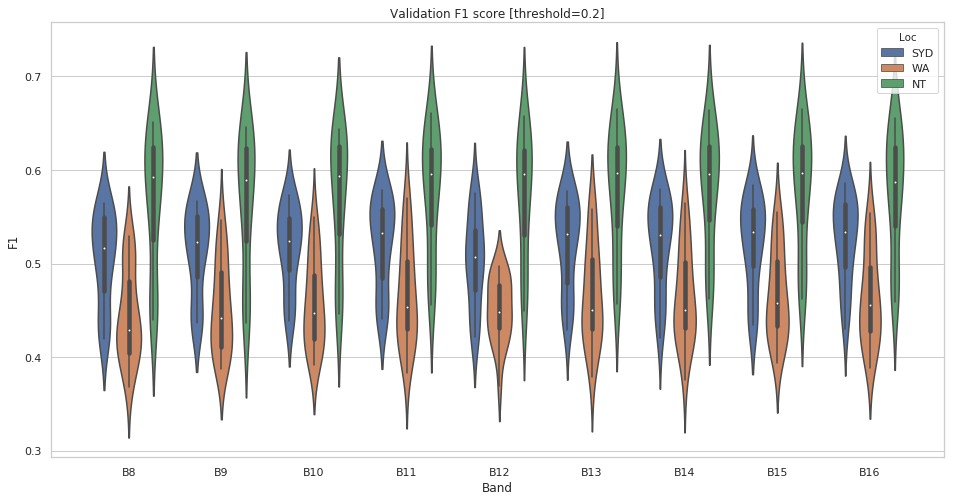

In [18]:
scr = "F1"

loc_map = {"SYD":"SE","NT":"NT","WA":"WA"}
scr_map = {"MSE":"MSE","F1":"F1","Rec":"Recall","Prec":"Precision"}

plt.clf()
plt.figure(figsize=(16,8))
ax = sns.violinplot(data=data[data['threshold [mm/h]']==0.2], x='Band', y=scr, hue='Loc')
ax.set_title(f"Validation {scr_map[scr]} score [threshold=0.2]")
plt.plot()

In [6]:
data[data['Band']=='B11']

,Band,MSE,Rec,Prec,F1,threshold [mm/h]
180,B11,0.182583,0.790470,0.374192,0.507938,0.2
181,B11,0.182583,0.592099,0.298457,0.396867,1.0
182,B11,0.182583,0.014674,0.411411,0.028337,5.0
183,B11,0.182528,0.789418,0.353743,0.488560,0.2
184,B11,0.182528,0.609038,0.294723,0.397223,1.0
185,B11,0.182528,0.002517,0.484536,0.005008,5.0
186,B11,0.182191,0.800749,0.357703,0.494506,0.2
187,B11,0.182191,0.577508,0.303404,0.397811,1.0
188,B11,0.182191,0.009774,0.441889,0.019124,5.0
189,B11,0.185103,0.780722,0.353177,0.486345,0.2
